# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf
from path_data import paths
from path_data.paths import monthly_pdf, year_pqt, year_day_types_pqt, TEMPLATE_2023, TEMPLATE_2022

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2025, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2025


In [5]:
if year is None:
    year = cur_year

pdf = monthly_pdf(year)
relpath(pdf)

'data/2025-PATH-Monthly-Ridership-Report.pdf'

In [6]:
if last_month is None:
    from PyPDF2 import PdfReader

    reader = PdfReader(pdf)
    num_pages = len(reader.pages)
    last_month = max(1, num_pages - 1)
    err(f"Inferred {last_month=}")

if template is None:
    template = paths.template(year)

Inferred last_month=4


In [7]:
with open(template, 'r') as f:
    rects = json.load(f)
rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 54.315,
  'x2': 577.575,
  'y1': 116.00001000000002,
  'y2': 238.40001,
  'width': 523.26,
  'height': 122.4},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 253.000035,
  'y2': 401.41003500000005,
  'width': 519.4350000000001,
  'height': 148.41},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 474.999975,
  'y2': 592.809975,
  'width': 519.4350000000001,
  'height': 117.81},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 56.61,
  'x2': 578.34,
  'y1': 611.000145,
  'y2': 753.290145,
  'width': 521.73,
  'height': 142.29},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 273.87,
  'x2': 573.75,
  'y1': 60.8175,
  'y2': 107.4825,
  'width': 299.88,
  'height': 46.665}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[116.00001000000002, 54.315, 238.40001, 577.575],
 [253.000035, 58.14, 401.41003500000005, 577.575],
 [474.999975, 58.14, 592.809975, 577.575],
 [611.000145, 56.61, 753.290145, 578.34],
 [60.8175, 273.87, 107.4825, 573.75]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}
tables

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street    103,218   3,832   2,840   1,956   1,782
  1          9th Street     89,377   3,264   2,473   1,771   1,931
  2         14th Street    137,547   5,242   3,486   2,174   2,412
  3         23rd Street    151,719   6,297   2,499   1,389   1,965
  4         33rd Street    515,046  20,113  10,537   7,444  10,374
  5     UPTOWN SUBTOTAL    996,907  38,748  21,835  14,734  18,463
  6                 WTC  1,081,649  42,893  19,990  15,723  19,021
  7   NEW YORK SUBTOTAL  2,078,556  81,641  41,825  30,458  37,483,
                       0          1        2       3       4       5
  0               Newark    394,078   16,042   6,384   4,781   6,269
  1             Harrison    142,274    5,835   2,378   1,560   1,996
  2       Journal Square    544,062   20,814  12,252   9,254  10,478
  3         Grove Street    403,294   15,506   9,690   6,477   6,497
  4       Exchange Place    271,799   10,932   4

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 5:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 5 tables
Pg 2: 5 tables
Pg 3: 5 tables
Pg 4: 5 tables


4

In [12]:
avgs = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"103,218","3,832","2,840","1,956","1,782",2025-01-01
1,9th Street,"89,377","3,264","2,473","1,771","1,931",2025-01-01
2,14th Street,"137,547","5,242","3,486","2,174","2,412",2025-01-01
3,23rd Street,"151,719","6,297","2,499","1,389","1,965",2025-01-01
4,33rd Street,"515,046","20,113","10,537","7,444","10,374",2025-01-01
5,UPTOWN SUBTOTAL,"996,907","38,748","21,835","14,734","18,463",2025-01-01
6,WTC,"1,081,649","42,893","19,990","15,723","19,021",2025-01-01
7,NEW YORK SUBTOTAL,"2,078,556","81,641","41,825","30,458","37,483",2025-01-01
0,Newark,"394,078","16,042","6,384","4,781","6,269",2025-01-01
1,Harrison,"142,274","5,835","2,378","1,560","1,996",2025-01-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,103218,3832,2840,1956,1782,2025-01-01
1,9th Street,89377,3264,2473,1771,1931,2025-01-01
2,14th Street,137547,5242,3486,2174,2412,2025-01-01
3,23rd Street,151719,6297,2499,1389,1965,2025-01-01
4,33rd Street,515046,20113,10537,7444,10374,2025-01-01
5,UPTOWN SUBTOTAL,996907,38748,21835,14734,18463,2025-01-01
6,WTC,1081649,42893,19990,15723,19021,2025-01-01
7,NEW YORK SUBTOTAL,2078556,81641,41825,30458,37483,2025-01-01
0,Newark,394078,16042,6384,4781,6269,2025-01-01
1,Harrison,142274,5835,2378,1560,1996,2025-01-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station               object
total                  int64
avg weekday            int64
avg sat                int64
avg sun                int64
avg holiday            int64
month          datetime64[s]
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[2:4]
])
sums

,0,1,2,3,4,5,date
0,Christopher Street,"3,330","80,470","11,360","7,824","3,564",2025-01-01
1,9th Street,"2,883","68,542","9,891","7,083","3,861",2025-01-01
2,14th Street,"4,437","110,084","13,943","8,697","4,823",2025-01-01
3,23rd Street,"4,894","132,236","9,997","5,557","3,929",2025-01-01
4,33rd Street,"16,614","422,373","42,149","29,776","20,748",2025-01-01
5,UPTOWN SUBTOTAL,"32,158","813,705","87,340","58,937","36,925",2025-01-01
6,WTC,"34,892","900,754","79,961","62,893","38,041",2025-01-01
7,NEW YORK SUBTOTAL,"67,050","1,714,459","167,301","121,830","74,966",2025-01-01
0,Newark,"12,712","336,882","25,536","19,123","12,537",2025-01-01
1,Harrison,"4,589","122,534","9,510","6,238","3,992",2025-01-01


In [17]:
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3330,80470,11360,7824,3564,2025-01-01
1,9th Street,2883,68542,9891,7083,3861,2025-01-01
2,14th Street,4437,110084,13943,8697,4823,2025-01-01
3,23rd Street,4894,132236,9997,5557,3929,2025-01-01
4,33rd Street,16614,422373,42149,29776,20748,2025-01-01
5,UPTOWN SUBTOTAL,32158,813705,87340,58937,36925,2025-01-01
6,WTC,34892,900754,79961,62893,38041,2025-01-01
7,NEW YORK SUBTOTAL,67050,1714459,167301,121830,74966,2025-01-01
0,Newark,12712,336882,25536,19123,12537,2025-01-01
1,Harrison,4589,122534,9510,6238,3992,2025-01-01


In [18]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [19]:
sums.dtypes

station                 object
avg daily                int64
total weekday            int64
total sat                int64
total sun                int64
total holiday            int64
month            datetime64[s]
dtype: object

In [20]:
def parse_nums(month, tbl):
    assert len(tbl) == 3
    assert all(tbl.iloc[0] == 'Average')
    tbl.columns = tbl.iloc[1].str.lower()
    tbl.columns.name = None
    tbl = tbl.iloc[2:]
    tbl.index = [month]
    tbl.index.name = 'month'
    return tbl.astype(int)
    
nums = pd.concat([
    parse_nums(month=month, tbl=dfs[-1])
    for month, dfs in tables.items()
])
nums.columns = [ f'{c}s' for c in nums.columns ]
nums

,weekdays,saturdays,sundays,holidays
month,,,,
1,21,4,4,2
2,19,4,4,1
3,21,5,5,0
4,22,4,4,0


In [21]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2025-01-01 Christopher Street        3330         3832     2840     1956   
           9th Street                2883         3264     2473     1771   
           14th Street               4437         5242     3486     2174   
           23rd Street               4894         6297     2499     1389   
           33rd Street              16614        20113    10537     7444   
           UPTOWN SUBTOTAL          32158        38748    21835    14734   
           WTC                      34892        42893    19990    15723   
           NEW YORK SUBTOTAL        67050        81641    41825    30458   
           Newark                   12712        16042     6384     4781   
           Harrison                  4589         5835     2378     1560   
           Journal Square           17550        20814    12252     9254   
           Grove Street             13009        15506     9690     6477   
           Exchange Place            8768        10932     4904     3411   
           Newport                   9012        11432     4667     3241   
           Hoboken                  13142        15993     9441     5588   
           NEW JERSEY SUBTOTAL      78783        96554    49714    34311   
           MONTHLY TOTAL           145833       178195    91540    64768   
2025-02-01 Christopher Street        2921         3344     2423     1684   
           9th Street                3264         3660     2858     2087   
           14th Street               4301         4945     3313     2585   
           23rd Street               4659         5777     2619     1937   
           33rd Street              15939        19035    10645     7911   
           UPTOWN SUBTOTAL          31084        36761    21858    16203   
           WTC                      32917        41089    17599    12963   
           NEW YORK SUBTOTAL        64001        77850    39457    29166   
           Newark                   13359        16959     6243     4556   
           Harrison                  4902         6261     2425     1511   
           Journal Square           18925        22459    13074     9426   
           Grove Street             13898        16325    10811     6924   
           Exchange Place            9501        11970     4998     3356   
           Newport                  12596        15210     8418     5628   
           Hoboken                   1840         2712        0        0   
           NEW JERSEY SUBTOTAL      75022        91896    45968    31400   
           MONTHLY TOTAL           139022       169747    85425    60566   
2025-03-01 Christopher Street        3820         4181     3697     2429   
           9th Street                3511         3960     3235     1902   
           14th Street               5378         6003     4814     3317   
           23rd Street               5420         6853     2969     1854   
           33rd Street              18565        22051    13091     9397   
           UPTOWN SUBTOTAL          36694        43048    27806    18899   
           WTC                      37271        45505    23539    16420   
           NEW YORK SUBTOTAL        73965        88552    51345    35319   
           Newark                   14500        18295     7835     5229   
           Harrison                  5368         6519     3845     2059   
           Journal Square           19289        22597    14684     9997   
           Grove Street             14609        16971    12024     7275   
           Exchange Place            9479        11724     5836     3692   
           Newport                  10021        12500     5997     3633   
           Hoboken                  14373        16969    11669     6176   
           NEW JERSEY SUBTOTAL      87639       105574    61890    38060   
           MONTHLY TOTAL           161604       194127   113235    73379   
2025

In [22]:
path = year_pqt(year)
df.to_parquet(path)
err(f"Wrote {relpath(path)}")

Wrote data/2025.pqt


In [23]:
nums_path = year_day_types_pqt(year)
nums.to_parquet(nums_path)
err(f"Wrote {relpath(nums_path)}")

Wrote data/2025-day-types.pqt


In [24]:
import plotly.express as px
from IPython.display import Image

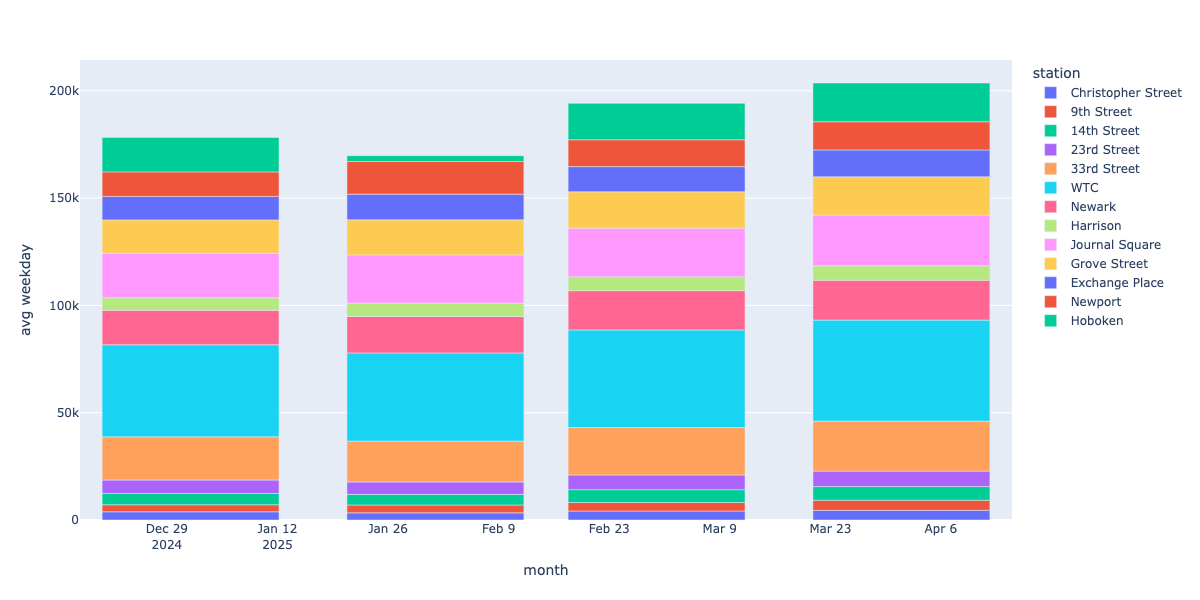

In [25]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))